## This is VANS algorithm applied to amplitude damping channel discrimination. Note that the gates that VANs appends to the circuit are either CNOTs or Rx or Rz rotations.

In [93]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import cirq
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt

from utilities.circuit_basics import Basic
from utilities.idinserter import IdInserter
from utilities.qmodels import *
from utilities.variational import Minimizer
from utilities.simplifier import Simplifier
from utilities.unitary_killer import UnitaryMurder
from utilities.evaluator import Evaluator


start = datetime.now()

basic = Basic(n_qubits=3)
inserter = IdInserter(n_qubits=3)
minimizer = Minimizer(n_qubits=3, epochs=10**3)
simplifier = Simplifier(n_qubits=basic.n_qubits)
killer = UnitaryMurder(minimizer=minimizer)

args={"problem_name":"QADC", "params":[.1,1.], "n_qubits":3}
evaluator = Evaluator(args = args)  #evloader = Evaluator(args = args, loading=True)

eta = 0.1

### CREATE INITIAL CIRCUIT CONSISTING ON ENCODER CHANNEL DECODER ####
circuit=[]
circuit = [basic.give_gate_template(k, block_id=0, trainable=True) for k in basic.rotation_series(1)]
circuit += [basic.give_gate_template(k, block_id=0, trainable=True) for k in basic.rotation_series(0)]
circuit += basic.give_channel_circuit_db([1,2], eta=eta, block_id=1) 
circuit += [basic.give_gate_template(k, block_id=2, trainable=True) for k in basic.rotation_series(1)]
circuit += [basic.give_gate_template(k, block_id=2, trainable=True) for k in basic.rotation_series(1)]
circuit, symbols, circuit_db = basic.give_circuit(circuit)

#### PREPARE BATCH OF CHANNELS ####
batch = basic.prepare_channel_discrimination_circuits(circuit_db)

##### TRAIN ONCE #####
error_prob, symbol_to_value, training_evolution1 = minimizer.channel_discrimination(batch)
## update database param_values
circuit_db = basic.update_circuit_db_param_values(circuit_db, symbol_to_value)


evaluator.add_step(circuit_db, error_prob, relevant=True)

print(evaluator.displaying["information"])


for it_vans in range(1):
    info = "Iteration number {}\nTime from start {}\nLowest Perr found {}\n\n".format(it_vans, str(datetime.now()-start), np.round(evaluator.lowest_energy.numpy(),3) )
    print(info)
    
    evaluator.displaying["information"] += info
    ### ADD IDENTITIES ALL OVER THE CIRCUIT ###
    mutated_circuit_db = inserter.place_identities(circuit_db)
    
    ### SIMPLIFY CIRCUIT ####
    simplified_circuit_db = simplifier.simplify_blocks(mutated_circuit_db)
    
    ### TRAIN (MUTATED+SIMPLIFIED) CIRCUIT
    batch_simplified = basic.prepare_channel_discrimination_circuits(simplified_circuit_db)
    perr, symbol_to_value, training_evolution = minimizer.channel_discrimination(batch_simplified)
    simplified_circuit_db = basic.update_circuit_db_param_values(simplified_circuit_db, symbol_to_value)

    accept_mutation = evaluator.accept_energy(error_prob)
    
    if accept_mutation == True:
        ## Kill unnecessary gates + simplification rules if mutation is accepted
        lmax = len(circuit_db["trainable"] == True)
        reduced = True
        cnt=0
        while reduced and cnt<lmax:
            # KILL single-qubit gates 
            killed_circuit_db, perr, reduced, unitaries_killed = killer.unitary_slaughter(simplified_circuit_db)
            simplified_circuit_db = simplifier.simplify_blocks(killed_circuit_db)
            cnt+=1
            
    ### save results of iteration ###
    evaluator.add_step(simplified_circuit_db, perr, relevant=accept_mutation)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

 Hola, I'm VANS, and current local time is 2021-10-12 18:57:58.249814 

Iteration number 0
Time from start 0:00:02.057763
Lowest Perr found 0.1080000028014183




In [115]:
circuit

(0, 0): ───Rx(th_0)───Rz(th_3)───Rx(th_8)───Rx(th_11)─────────────────────────────────────────────────────────────────

(0, 1): ───Rx(th_1)───Rz(th_4)───H──────────X────────────────────────X───H────────────────X───Rx(th_9)────Rx(th_12)───
                                            │                        │                    │
(0, 2): ───Rx(th_2)───Rz(th_5)───H──────────@───────────Ry(0.032π)───@───H───Ry(0.032π)───@───Rx(th_10)───Rx(th_13)───

In [104]:
def bound_EA(eta0, eta1):
    gamma = np.cos(eta0) + np.cos(eta1)
    y_star = np.max([0, (gamma-1)/(gamma-2)])
    sec_term = lambda y: (1-y)*gamma + np.sqrt((1-y)*(4*y + (1-y)*(gamma**2)))
    return (np.cos(eta1)-np.cos(eta0))*sec_term(y_star)

In [106]:
def pmancini(eta0, eta1):
    #https://arxiv.org/pdf/2009.01000.pdf
    gamma = np.cos(eta0)+np.cos(eta1)
    if gamma<1/np.sqrt(2):
        return (2 + (np.cos(eta1)-np.cos(eta0))/np.sqrt(1-gamma**2))/4
    else:
        return (np.sin(eta0)**2 + np.cos(eta1)**2)/2

def pmancini_EA(eta0,eta1):
    gamma = np.cos(eta0)+np.cos(eta1)
    return (1+np.sin(eta0-eta1))/2

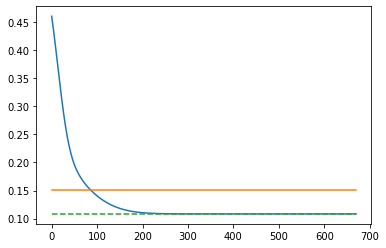

In [116]:
histo = training_evolution1.history["loss"]
plt.plot(histo)
plt.plot([1-pmancini(1.,0.1)]*len(histo))
plt.plot([1-pmancini_EA(1.,0.1)]*len(histo), '--')